In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

# Task 1: Preprocess Data

In [2]:
# download and load datasets into Pandas Dataframe
hospital_data = pd.read_csv('https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv')
daily_symptom_data = pd.read_csv('https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_daily_symptoms_dataset.csv')

## Convert daily symptom data to weekly symptom data

In [3]:
# drop unnecessary columns
daily_symptom_data.drop(['country_region', 'country_region_code', 'sub_region_1', 'sub_region_1_code', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace=True)

# group symptom data by region
d = dict(tuple(daily_symptom_data.groupby('open_covid_region_code')))

summed_daily_data = []

for region, region_data in d.items():

    # get earliest start of week date
    min_date_str = region_data['date'].min()
    min_date = date(*map(int, min_date_str.split('-')))
    start_week = min_date + timedelta(days=(7 - min_date.weekday()) % 7)
    end_week = start_week + timedelta(days=7)

    # convert date strings to actual date type
    region_data['date'] = region_data['date'].map(lambda x: date(*map(int, x.split('-'))))

    # select data from week
    weekly_data = region_data[region_data['date'] >= start_week][region_data['date'] < end_week]
    weekly_data = weekly_data[[s for s in daily_symptom_data.columns.values if s.startswith('symptom:')]]

    # sum daily symptom data for each full week in the region's data set
    while weekly_data.shape[0] == 7:
        col_vals = [region, start_week]
        col_vals.extend(weekly_data.mean(skipna=False).values)
        summed_daily_data.append(col_vals)

        start_week = end_week
        end_week = start_week + timedelta(days=7)
        weekly_data = region_data[region_data['date'] >= start_week][region_data['date'] < end_week]
        weekly_data = weekly_data[[s for s in daily_symptom_data.columns.values if s.startswith('symptom:')]]

symptoms_data = pd.DataFrame(data=summed_daily_data, columns=daily_symptom_data.columns.values)

## Clean symptom data

In [4]:
# Allow symptom data to have some missing data points
region_sparseness_thresh = 0.9

symptom_names = [s for s in symptoms_data.columns.values if s.startswith('symptom:')]
num_weeks = symptoms_data['open_covid_region_code'].value_counts()[0]

# Split by regions
symptoms_data.dropna(axis='columns', how='all', inplace=True)

region_symptoms = dict(tuple(symptoms_data.groupby('open_covid_region_code')))

# Drop symptoms from regions that are incomplete
for region, region_data in region_symptoms.items():
    region_data.dropna(axis='columns', how='all', inplace=True)
    region_data = region_data.loc[: , (region_data.count() >= num_weeks*region_sparseness_thresh)]
    region_symptoms[region] = region_data.loc[: , (region_data.count() >= num_weeks*region_sparseness_thresh)]

filtered_symptom_data = pd.concat(region_symptoms, ignore_index=True)

## Interpolate and Normalize symptom data

In [5]:
interpolated_region_symptoms = dict()
for region, region_data in region_symptoms.items():
    for s in region_data.columns.values:
        if s.startswith('symptom:'):
            
            # interpolate
            region_data[s] = region_data[s].interpolate()
            
            # normalize by dividing by median of symptom-region pair
            region_data[s] = region_data[s].truediv(region_data[s].median())

    interpolated_region_symptoms[region] = region_data

interpolated_symptom_data = pd.concat(interpolated_region_symptoms, ignore_index=True)

## Clean hospital data

In [6]:
# drop non USA regions
hospital_data = hospital_data[hospital_data['open_covid_region_code'].str.contains('US-')]

# drop irrelavent data
hospital_data = hospital_data.filter(['open_covid_region_code', 'date', 'hospitalized_new'])

# aggregate daily to weekly
d = dict(tuple(hospital_data.groupby('open_covid_region_code')))

aggregated_data = []
min_start_date = date(*map(int, hospital_data['date'].min().split('-')))

for region, region_data in d.items():

    # skip if total hospitalization data is zero
    if region_data['hospitalized_new'].sum() == 0:
        continue

    # get earliest start of week date
    min_date_str = region_data['date'].min()
    min_date = date(*map(int, min_date_str.split('-')))
    start_week = min_date + timedelta(days=(7 - min_date.weekday()) % 7)
    end_week = start_week + timedelta(days=7)

    # Set common start date
    min_start_date = max(min_start_date, start_week)

    # convert date strings to actual date type
    region_data['date'] = region_data['date'].map(lambda x: date(*map(int, x.split('-'))))

    # select data from week
    weekly_data = region_data[region_data['date'] >= start_week][region_data['date'] < end_week]

    # sum hospital for each full week in the region's data set
    while weekly_data.shape[0] == 7:
        aggregated_data.append([region, start_week, weekly_data['hospitalized_new'].sum()])

        start_week = end_week
        end_week = start_week + timedelta(days=7)
        weekly_data = region_data[region_data['date'] >= start_week][region_data['date'] < end_week]

filtered_hospital_data = pd.DataFrame(data=aggregated_data, columns=['open_covid_region_code', 'date', 'hospitalized_new'])

# Drop all rows before common start date
filtered_hospital_data = filtered_hospital_data[filtered_hospital_data['date'] >= min_start_date]

## Join symptom and hospital data

In [7]:
merged_data = pd.merge(interpolated_symptom_data, filtered_hospital_data, on=['open_covid_region_code', 'date'])
merged_data.dropna(axis='columns', how='any', inplace=True)

# Drop symptoms with missing region data
merged_data.dropna(axis='columns', how='any', inplace=True)

# interpolated_merged_data.to_csv('../data/interpolated_merged_data.csv')

## Remove Outliers

In [8]:
from scipy import stats

# merged_data = merged_data.loc[np.abs(stats.zscore(merged_data['hospitalized_new'])) < 3]


# Task 2: Data Visualization

In [9]:
import matplotlib.pyplot as plt

chosen_symptoms = ['symptom:Cough', 'symptom:Common cold' , 'symptom:Fever']
symptom_names = [s for s in merged_data.columns.values if s.startswith('symptom:')]
region_names = merged_data['open_covid_region_code'].unique()

by_state = merged_data.groupby('open_covid_region_code')

date_data = by_state.get_group(region_names[0]).sort_values(by=['date'])['date']

## Popularity of symptoms

In [10]:
from ipywidgets import widgets, interactive

hospitalization = widgets.Dropdown(
    options=[True, False],
    value=False,
    description='Show hospitalizations: ',
)

symptom = widgets.Dropdown(
    options=symptom_names,
    value='symptom:Fever',
    description='Symptoms: ',
)

region = widgets.Dropdown(
    options=['All of USA'] + list(region_names),
    value='All of USA',
    description='Regions: ',
)

def plot_graph(region, symptom, hospitalization):
    regions = region_names
    alpha = 0.2

    fig, symptom_plt = plt.subplots()
    hosp_plt = symptom_plt.twinx()

    # Aggregate hospital data across regions
    hospital_data = merged_data.groupby('date').sum().filter(['hospitalized_new'])

    # Adjust values if selecting individual region
    if region != 'All of USA':
        regions = [region]
        alpha = 0.9
        hospital_data = merged_data.loc[merged_data['open_covid_region_code'] == region].groupby('date').sum().filter(['hospitalized_new'])

    hosp_plt.set_ylabel('New Hospitalizations', color='tab:blue')
    hosp_plt.tick_params(axis='y', labelcolor='tab:blue')

    # Show hospitalization data only if selected
    if hospitalization:
        hosp_plt.plot(hospital_data.index.values, hospital_data['hospitalized_new'].values, color='tab:blue', alpha=0.8)

    for index, region_name in enumerate(regions):

        temp = by_state.get_group(region_name).sort_values(by=['date'])[symptom]

        # calculate median and divide the values in array by median
        temp = np.true_divide(temp, np.median(temp))

        symptom_plt.plot(date_data, temp, color='tab:red', alpha=alpha)

    symptom_plt.tick_params(axis='y', labelcolor='tab:red')
    symptom_plt.set_ylabel('Relative Search Frequency', color='tab:red')
    symptom_plt.set_xlabel('Date')
    fig.tight_layout()
    plt.title(symptom[len('symptom:'):] + " : " + region)
    plt.xticks(rotation=90)
    plt.show()

interactive(plot_graph, region=region, symptom=symptom, hospitalization=hospitalization)

interactive(children=(Dropdown(description='Regions: ', options=('All of USA', 'US-AL', 'US-AR', 'US-AZ', 'US-CO', 'US-CT', 'US-FL', 'US-GA', 'US-HI', 'US-ID', 'US-IN', 'US-KS', 'US-KY', 'US-MA', 'US-MD', 'US-ME', 'US-MN', 'US-MS', 'US-MT', 'US-ND', 'US-NE', 'US-NH', 'US-NJ', 'US-NM', 'US-NY', 'US-OH', 'US-OK', 'US-OR', 'US-RI', 'US-SC', 'US-SD', 'US-TN', 'US-UT', 'US-VA', 'US-WA', 'US-WI', 'US-WY'), value='All of USA'), Dropdown(description='Symptoms: ', index=33, options=('symptom:Abdominal obesity', 'symptom:Abdominal pain', 'symptom:Acne', 'symptom:Alcoholism', 'symptom:Allergy', 'symptom:Anemia', 'symptom:Anxiety', 'symptom:Arthritis', 'symptom:Asthma', 'symptom:Attention deficit hyperactivity disorder', 'symptom:Autoimmune disease', 'symptom:Back pain', 'symptom:Bleeding', 'symptom:Bloating', 'symptom:Bone fracture', 'symptom:Bruise', 'symptom:Burn', 'symptom:Candidiasis', 'symptom:Chest pain', 'symptom:Common cold', 'symptom:Constipation', 'symptom:Cough', 'symptom:Cramp', 'symptom:Dementia', 'symptom:Depression', 'symptom:Dermatitis', 'symptom:Diabetes', 'symptom:Diarrhea', 'symptom:Dizziness', 'symptom:Dysmenorrhea', 'symptom:Epilepsy', 'symptom:Erectile dysfunction', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Flatulence', 'symptom:Gastroesophageal reflux disease', 'symptom:Generalized anxiety disorder', 'symptom:Gout', 'symptom:Hair loss', 'symptom:Hay fever', 'symptom:Headache', 'symptom:Heart arrhythmia', 'symptom:Heartburn', 'symptom:Hemorrhoids', 'symptom:Hives', 'symptom:Hypertension', 'symptom:Hypotension', 'symptom:Hypothyroidism', 'symptom:Implantation bleeding', 'symptom:Indigestion', 'symptom:Infection', 'symptom:Inflammation', 'symptom:Insomnia', 'symptom:Iron deficiency', 'symptom:Itch', 'symptom:Kidney stone', 'symptom:Knee Pain', 'symptom:Low back pain', 'symptom:Major depressive disorder', 'symptom:Migraine', 'symptom:Myocardial infarction', 'symptom:Nausea', 'symptom:Neck pain', 'symptom:Obesity', 'symptom:Otitis', 'symptom:Pain', 'symptom:Panic attack', 'symptom:Paresthesia', 'symptom:Perspiration', 'symptom:Psychosis', 'symptom:Scar', 'symptom:Sciatica', 'symptom:Sinusitis', 'symptom:Skin condition', 'symptom:Skin rash', 'symptom:Skin ulcer', 'symptom:Sleep apnea', 'symptom:Sleep disorder', 'symptom:Sore throat', 'symptom:Stroke', 'symptom:Swelling', 'symptom:Type 2 diabetes', 'symptom:Urinary tract infection', 'symptom:Vaginal discharge', 'symptom:Vertigo', 'symptom:Vomiting', 'symptom:Wart', 'symptom:Weight gain', 'symptom:Xeroderma'), value='symptom:Fever'), Dropdown(description='Show hospitalizations: ', index=1, options=(True, False), value=False), Output()), _dom_classes=('widget-interact',))

## PCA

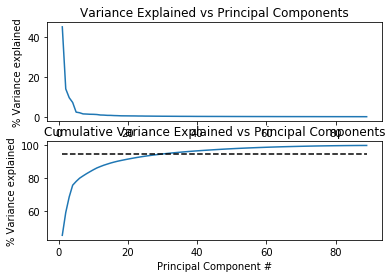

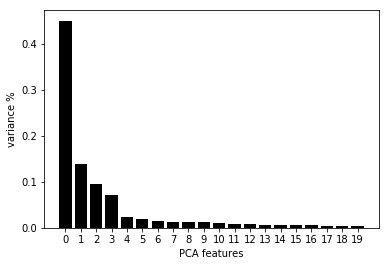

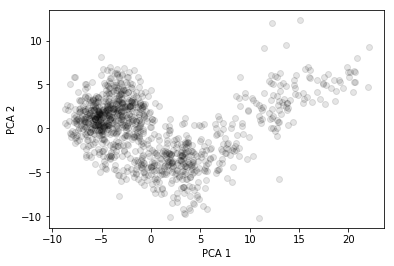

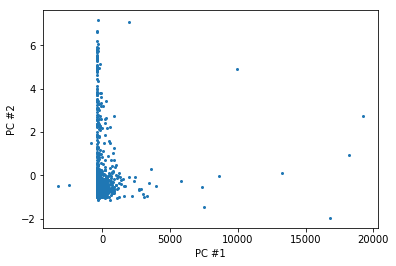

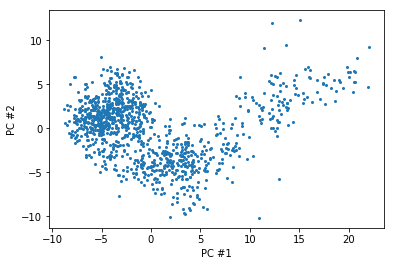

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#PCA
#get only columns with symptoms
#merged_data = pd.read_csv('../data/interpolated_merged_data_scaled.csv')
X=merged_data[merged_data.columns[3:len(symptom_names)+3]]
# print(X)
#Figure out how many components (kinda useless)
pca2 = PCA()
pca2.fit_transform(StandardScaler().fit_transform(X))
num_pc_components = len(pca2.explained_variance_ratio_)
plt.subplot(2,1,1)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*pca2.explained_variance_ratio_)
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Variance Explained vs Principal Components")

plt.subplot(2,1,2)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*np.cumsum(pca2.explained_variance_ratio_))
plt.plot(np.linspace(1,num_pc_components,num_pc_components),95*np.ones((num_pc_components,)),'k--')
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Cumulative Variance Explained vs Principal Components")
plt.show()


pca = PCA(n_components=20)
principalComponents = pca.fit_transform(StandardScaler().fit_transform(X))# Plot the explained variances
#principalComponents = pca.fit(X)# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
plt.show()

plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

#PCA graph
markersize=4
pca = PCA(n_components=3)
#pca.fit(X)
#X_reduced = pca.transform(X)
X_reduced = pca.fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:,1], s=markersize)
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.show()

#PCA graph with standardized data
markersize=4
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(StandardScaler().fit_transform(X))
plt.scatter(X_reduced[:,0], X_reduced[:,1], s=markersize)
plt.clim(-0.5,2.5)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.show()

## Clustering

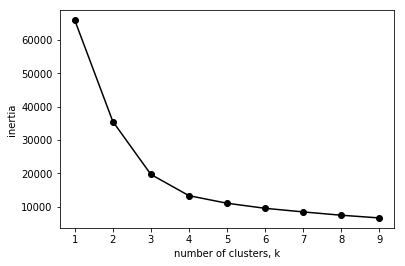

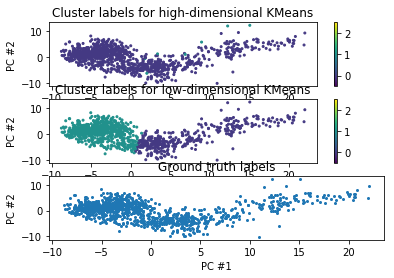

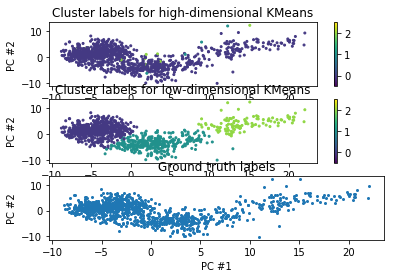

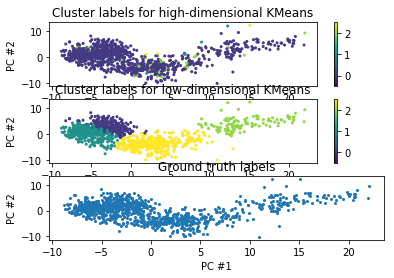

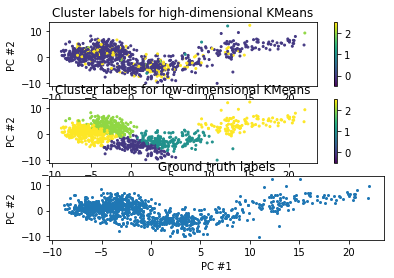

In [12]:
from sklearn.cluster import KMeans

#knee rule to determine number of clusters
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    #model.fit(X)
    model.fit(PCA_components.iloc[:, :3])
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

ks = range(2, 6)
for k in ks:
    #Clusters
    clusterNum=k
    #high is raw data
    kmeans_high = KMeans(n_clusters=clusterNum, random_state=0)
    kmeans_high.fit(X)
    y_pred_high = kmeans_high.predict(X)

    #low is reduced dimensionality data
    kmeans_low = KMeans(n_clusters=clusterNum, random_state=0)
    kmeans_low.fit(X_reduced)
    y_pred_low = kmeans_low.predict(X_reduced)

    # Plot 3 scatter plots -- two for high and low dimensional clustering results and one indicating the ground truth labels

    plt.subplot(3,1,1)
    plt.scatter(X_reduced[:,0], X_reduced[:,1], s=markersize, c=y_pred_high)
    plt.colorbar(ticks=[0,1,2])
    plt.clim(-0.5,2.5)
    plt.xlabel("PC #1")
    plt.ylabel("PC #2")
    plt.title("Cluster labels for high-dimensional KMeans")

    plt.subplot(3,1,2)
    plt.scatter(X_reduced[:,0], X_reduced[:,1], s=markersize, c=y_pred_low)
    plt.colorbar(ticks=[0,1,2])
    plt.clim(-0.5,2.5)
    plt.xlabel("PC #1")
    plt.ylabel("PC #2")
    plt.title("Cluster labels for low-dimensional KMeans")

    plt.subplot(3,1,3)
    #plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('viridis',3))
    plt.scatter(X_reduced[:,0], X_reduced[:,1], s=markersize)
    #plt.colorbar(ticks=[0,1,2], format=formatter)
    plt.clim(-0.5,2.5)
    plt.xlabel("PC #1")
    plt.ylabel("PC #2")
    plt.title("Ground truth labels")
    plt.show()

# Task 3: Supervised Learning

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import VarianceThreshold

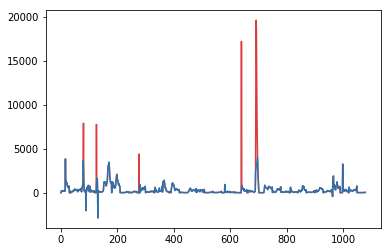

In [14]:
# Remove hospitalization outliers
from scipy import stats

plt.plot(merged_data['hospitalized_new'], color='tab:red', alpha=0.9)

data = merged_data.loc[np.abs(stats.zscore(merged_data['hospitalized_new'])) < 3]
# data = merged_data

# symptom_data = data[symptom_names]

# threshold_n=0.90
# vt = VarianceThreshold(threshold=(threshold_n * (1 - threshold_n)))
# vt.fit(symptom_data)
# selected_symptoms = symptom_data[symptom_data.columns[vt.get_support(indices=True)]]
# data = pd.concat([data[['date', 'open_covid_region_code', 'hospitalized_new']], selected_symptoms], axis=1)

# symptom_names = selected_symptoms.columns.values

plt.plot(data['hospitalized_new'], color='tab:blue', alpha=0.9)
plt.show()

## Part 1

## 

In [15]:
validation_r2_score = []
validation_cost = []

L = 5
num_Ks = 20

for fold in range(L):
    train_list = []
    validation_list = []

    region_index = fold

    # Split regions for cross validation
    for region in region_names:
        if region_index % L == 0:
            validation_list.append(data.loc[data['open_covid_region_code'] == region])
        else:
            train_list.append(data.loc[data['open_covid_region_code'] == region])

        region_index += 1

    train_set = pd.concat(train_list, ignore_index=True)
    validation_set = pd.concat(validation_list, ignore_index=True)

    # Prepare training and test data
    training_data = train_set.loc[:, symptom_names].values
    training_labels = train_set.loc[:, 'hospitalized_new'].values
    validation_data = validation_set.loc[:, symptom_names].values
    validation_labels = validation_set.loc[:, 'hospitalized_new'].values

    # Perform KNN
    r2_results = []
    cost_results = []

    for K in range(1, num_Ks+1):
        knn = KNeighborsRegressor(n_neighbors=K)

        knn.fit(training_data, training_labels)

        test_predicted = knn.predict(validation_data)

        cost = 0
        for u in (range(len(test_predicted))):
            mse = (test_predicted[u] - validation_labels[u])**2
            cost += mse
        cost = cost/(len(test_predicted))

        knn_score = knn.score(validation_data, validation_labels)

        r2_results.append(knn_score)
        cost_results.append(cost)

    validation_r2_score.append(r2_results)
    validation_cost.append(cost_results)

# Report KNN results
for K in range(1, num_Ks+1):
    mean_r2 = 0
    mean_cost = 0

    for i in range(L):
        mean_r2 += validation_r2_score[i][K-1]
        mean_cost += validation_cost[i][K-1]
    
    mean_r2 /= L
    mean_cost /= L

    print('K =', K,'\t: r^2 =', mean_r2, '\t: cost =', mean_cost)

K = 1 	: r^2 = -1.12108479076 	: cost = 400623.630223
K = 2 	: r^2 = -0.542502855795 	: cost = 293386.726852
K = 3 	: r^2 = -0.346272504079 	: cost = 257155.509521
K = 4 	: r^2 = -0.187502570984 	: cost = 236326.667552
K = 5 	: r^2 = -0.0985878614352 	: cost = 221952.32801
K = 6 	: r^2 = -0.0631742123245 	: cost = 216922.029648
K = 7 	: r^2 = -0.0229797716387 	: cost = 211295.355314
K = 8 	: r^2 = -0.0147120218653 	: cost = 210673.86077
K = 9 	: r^2 = -0.00357937859598 	: cost = 209744.517767
K = 10 	: r^2 = -0.00323861869464 	: cost = 210811.22898
K = 11 	: r^2 = 0.000601285600502 	: cost = 210484.402489
K = 12 	: r^2 = 0.00679891793248 	: cost = 210339.716978
K = 13 	: r^2 = 0.000889764180546 	: cost = 211298.363804
K = 14 	: r^2 = 0.0101065968814 	: cost = 209549.857114
K = 15 	: r^2 = 0.0150001046113 	: cost = 209064.911215
K = 16 	: r^2 = 0.0189354518035 	: cost = 208486.441576
K = 17 	: r^2 = 0.0157693984363 	: cost = 209600.76961
K = 18 	: r^2 = 0.0139845109889 	: cost = 210415.

## Part 2